In [ ]:
!pip install gtts

  Created wheel for gtts-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4097 sha256=726f8375b4b6e60e7464d37322ba4d5b076292911d0ce96be3f40c30ddd8bb9d
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
Successfully built gtts-token


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from gtts import gTTS
import os
from IPython.display import Audio
import re

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1rtgmB6aqJf93bcEygGyGPQHRBUg9d03G" -O yolonewcnfg
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1NlVRw8EwUkexxsG4j0r3cjX8ShtoFowc" -O ycoconames


--2020-04-16 06:03:55--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   368KB/s    in 8m 20s  

2020-04-16 06:12:16 (485 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2020-04-16 06:12:17--  https://docs.google.com/uc?export=download&id=1rtgmB6aqJf93bcEygGyGPQHRBUg9d03G
Resolving docs.google.com (docs.google.com)... 173.194.215.102, 173.194.215.100, 173.194.215.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.215.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ias5uql08uqcvi2tst4rn9sulafbcgs8/1587017475000/18105196

In [ ]:
model = cv2.dnn.readNet("/content/yolov3.weights","/content/yolonewcnfg")



In [ ]:
classes = []
with open("/content/ycoconames","r") as f:
  classes = [line.strip() for line in f.readlines()]
layer_names = model.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in model.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))


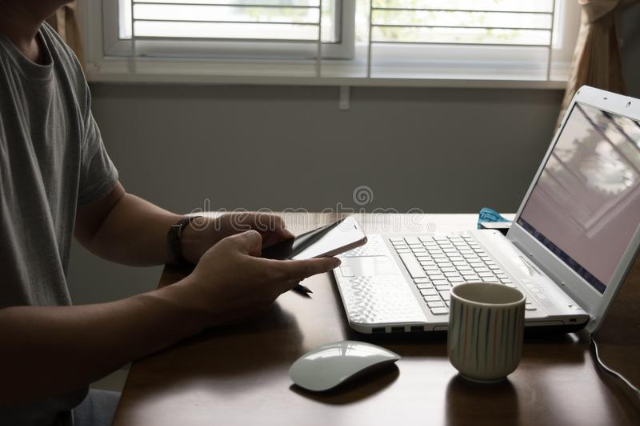

In [ ]:
img = cv2.imread("/content/image 8.jpg")
img = cv2.resize(img, None, fx=0.8, fy=0.8)
height, width, channels = img.shape
cv2_imshow(img)


In [ ]:
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
model.setInput(blob)
outs = model.forward(output_layers)

In [ ]:

class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [ ]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

In [ ]:
def generate_text(label,x,y,w,h):
  s = label + " is at the "
  cx = x + w/2
  cy = y + h/2

  if( cx > width/2):
    if(cy > height/2):
      s+="bottom right part of the image "
    else:
      s+="top right part of the image "
  else:
    if(cy>height/2):
      s+="bottom left part of the image "
    else:
      s+="top left part of the image "

  return s

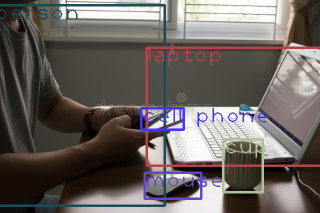

In [ ]:
font = cv2.FONT_HERSHEY_PLAIN
text = ""
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 3)
        cv2.putText(img, label, (x, y + 30), font, 3, color, 2)
        text+=generate_text(label,x,y,w,h)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
cv2_imshow(img)


In [ ]:
print(text)

person is at the top left part of the image laptop is at the top right part of the image cell phone is at the bottom right part of the image cup is at the bottom right part of the image mouse is at the bottom right part of the image 


In [ ]:
language="en"
obj = gTTS(text,lang=language)

In [ ]:
obj.save("audio.mp3")
Audio('audio.mp3',autoplay=True)